In [1]:
import bigQueryPlotting as bq
import matplotlib.pyplot as plt
import pandas
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# BigQuery examples

## A simple query: selecting helium

In [2]:
def selectHelium():
    # Querying the database through the Pandas API                                                                                                                                                                   
    # Looking for 3 helium events:                                                                                                                                                                                
    aSimpleQuery='SELECT * FROM AMS.Data WHERE 1.8 < ChargeTOF < 2.2 LIMIT 3'
    heliumData=pandas.read_gbq( aSimpleQuery, project_id = "ams-test-kostya" )

    # Saving the DataFrame to file                                                                                                                                                                                   
    heliumData.to_csv('heliumData.txt')

    # The saved DataFrame can be retreived this way:                                                                                                                                                                 
    heliumDataFromFile=pandas.read_csv('heliumData.txt');
    print heliumDataFromFile

selectHelium()

Job not yet complete...
   Unnamed: 0   Index         Run   Event       UTime    JMDCTime    ThetaS  \
0           0  638240  1367486517  638241  1367487877  1367487863 -0.900971   
1           1  638241  1367486517  638242  1367487877  1367487863 -0.900971   
2           2  638242  1367486517  638243  1367487877  1367487863 -0.900971   

       PhiS  Livetime  Latitude    ...        chiq_0    chiq_1    chiq_2  \
0  4.146101  0.857087 -0.787907    ...      0.123368  0.123368  0.123368   
1  4.146101  0.857087 -0.787907    ...      0.148435  0.148435  0.148435   
2  4.146103  0.857087 -0.787907    ...      0.000000  0.000000  0.000000   

     chiq_3    chiq_4    chiq_5  EdepTOF_0  EdepTOF_1  EdepTOF_2  EdepTOF_3  
0  0.123368  0.123368  0.123368   2.738969   2.871590   3.217149   2.842419  
1  0.148435  0.148435  0.148435   2.101750   1.516577   2.174285   3.522559  
2  0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   0.630541  

[3 rows x 62 columns]


## A join example : getting the exposure time above 5 GeV for our dataset   

In [3]:
def exposureTime():
    # The 'timeInSecInData' table contains one entry for every second present in our dataset                                                                                                                         
    # The 'cutoffs' table contain one entry for every second during the 3 years of data.                                                                                                                             
    #      goodSecond is a custom variable that indicates that the event is good (out of SAA, good lifetime fraction, etc.)                                                                                          
    theCommand="""                                                                                                                                                                                                   
            SELECT                                                                                                                                                                                                   
              SUM(AMS.cutoffs.Lifetime) as exposure_time_above_5_GeV                                                                                                                                                 
            FROM                                                                                                                                                                                                     
              AMS.cutoffs                                                                                                                                                                                            
              JOIN AMS.timeInSecInData                                                                                                                                                                               
              ON (AMS.timeInSecInData.JMDCTimeInSec = AMS.cutoffs.JMDCTime)                                                                                                                                          
            WHERE                                                                                                                                                                                                    
               AMS.cutoffs.goodSecond == 1                                                                                                                                                                           
               AND                                                                                                                                                                                                   
               IGRF40pos >= 5                                                                                                                                                                                        
        """

    print pandas.read_gbq(theCommand, project_id='ams-test-kostya')

exposureTime()

Job not yet complete...
   exposure_time_above_5_GeV
0                     401924


## A 'group by' example : making a histogram by hand

In [4]:
def groupByExample():
    # Notice the HAVING instead of the WHERE clause.
    # It is used when setting a condition on an aliased variable                                                                                                                           
    theCommand="""                                                                                                                                                                                                   
        SELECT                                                                                                                                                                                                       
           CASE                                                                                                                                                                                                      
               WHEN            R < 2 THEN 0                                                                                                                                                                          
               WHEN R >= 2 AND R < 3 THEN 1                                                                                                                                                                          
               WHEN R >= 3 AND R < 4 THEN 2                                                                                                                                                                          
               WHEN R >= 4 AND R < 5 THEN 3                                                                                                                                                                          
               ELSE -1                                                                                                                                                                                               
           END as binningRigidity,                                                                                                                                                                                   
           COUNT(1) as nEntries                                                                                                                                                                                                
        FROM AMS.Data                                                                                                                                                                                                
        GROUP BY binningRigidity                                                                                                                                                                                     
        HAVING binningRigidity > -1                                                                                                                                                                                  
        ORDER BY binningRigidity"""
    print pandas.read_gbq(theCommand, project_id='ams-test-kostya')

groupByExample()

Job not yet complete...
   binningRigidity   nEntries
0                0  248011833
1                1   16785252
2                2   14634755
3                3   11935302


 # Histograms with bigQueryPlotting.py

SELECT (1+( INTEGER(FLOOR( ( (EnergyE) - (1))/(0.99) )) +0.5)*0.99) as binX,COUNT(1) FROM AMS.Data GROUP BY binX HAVING binX >= 1 AND binX < (100 ) ORDER BY binX
loading : SELECT (1+( INTEGER(FLOOR( ( (EnergyE) - (1))/(0.99) )) +0.5)*0.99) as binX,COUNT(1) FROM AMS.Data GROUP BY binX HAVING binX >= 1 AND binX < (100 ) ORDER BY binX
CACHED
SELECT  INTEGER(FLOOR( ( (R) - (0))/(0.2) ))  as binX,  INTEGER(FLOOR( ( (BetaTOF) - (0.5))/(0.006) ))  as binY,COUNT(1) FROM AMS.Data GROUP BY binX, binY HAVING binX >= 0 AND binX < (100) AND binY >= 0 AND binY < (100) ORDER BY binX,binY
loading : SELECT  INTEGER(FLOOR( ( (R) - (0))/(0.2) ))  as binX,  INTEGER(FLOOR( ( (BetaTOF) - (0.5))/(0.006) ))  as binY,COUNT(1) FROM AMS.Data GROUP BY binX, binY HAVING binX >= 0 AND binX < (100) AND binY >= 0 AND binY < (100) ORDER BY binX,binY
CACHED


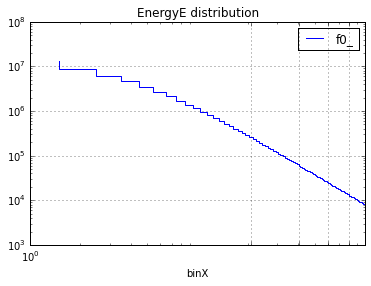

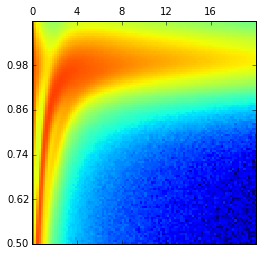

In [5]:
def histograms():
    # 1D plotting: EnergyE distribution                                                                                                                                                                              
    h=bq.hist(100,1,100,'EnergyE')
    h.plot(logy=True, logx=True, title='EnergyE distribution')


    # 2D plotting: rigidity [0-20] GeV Vs BetaTof [0.5-1]                                                                                                                                                            
    h2d=bq.hist2d(100,0,20,100,0.5,1.1,'R','BetaTOF')
    h2d.plot()

    plt.show()

histograms()
